In [1]:
!pip install -q numpy scipy pandas matplotlib seaborn fastcore missingno

In [1]:
from pathlib import Path

import pandas as pd
from pandas.api.types import CategoricalDtype

import numpy as np
from scipy import stats
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML

np.random.seed(42)

In [2]:
%matplotlib inline
import matplotlib as mpl

plt.rc('font', family='serif')
plt.rc('text', usetex=True)
mpl.rcParams['figure.dpi'] = 300

def savefig(name, **kwargs):
    params = dict(bbox_inches='tight', transparent="True", pad_inches=0)
    params.update(kwargs)
    plt.savefig(f'../images/{name}.png', **params)


In [3]:
from fastcore.basics import patch_to

@patch_to(pd.DataFrame)
def display(self): 
    display(HTML(self.to_html()))

## Dataset definition

Before starting our analysis of the dataset, we inspect the dataset description provided to identify each variable's data type and classify them into three types: numerical, ordinal, and nominal. The data type of a variable is important when choosing encoding and imputation methods for that variable. 
We identify that there are 80 variables in the dataset with the breakdown of 29 numerical variables, 19 ordinal variables, and 32 nominal variables.
We also define the category order for ordinal variables whose order cannot be inferred by `pandas`.

In [4]:
ORDINALS_INFO = [
    ('BsmtExposure',['NA', 'No', 'Mn', 'Av', 'Gd']),
    ('BsmtQual',['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('BsmtCond', ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('ExterQual',['NA','Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('ExterCond', ['NA','Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('FireplaceQu',['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('GarageCond',['NA','Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('GarageQual',['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('HeatingQC',['NA','Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('KitchenQual',['NA','Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('LandSlope',['Gtl', 'Mod', 'Sev']),
    ('PoolQC', ['NA', 'Fa', 'TA', 'Gd', 'Ex']),
    ('OverallQual', list(range(1, 11))),
    ('OverallCond', list(range(1, 11))),
    ('MoSold', None),
    ('YrSold', None),
    ('YearBuilt', None),
    ('YearRemodAdd', None),
    ('GarageYrBlt', None),
]
ORDINALS = [feat for feat, _ in ORDINALS_INFO]

NOMINALS = [
    'Alley',
    'BldgType',
    'BsmtFinType1',
    'BsmtFinType2',
    'CentralAir',
    'Condition1',
    'Condition2',
    'Electrical',
    'Exterior1st',
    'Exterior2nd',
    'Fence',
    'Foundation',
    'Functional',
    'GarageFinish',
    'GarageType',
    'Heating',
    'HouseStyle',
    'LandContour',
    'LotConfig',
    'LotShape',
    'MSSubClass',
    'MSZoning',
    'MasVnrType',
    'MiscFeature',
    'Neighborhood',
    'PavedDrive',
    'RoofMatl',
    'RoofStyle',
    'SaleCondition',
    'SaleType',
    'Street',
    'Utilities'
]

NUMERICALS = [
    '1stFlrSF',
    '2ndFlrSF',
    '3SsnPorch',
    'BedroomAbvGr',
    'BsmtUnfSF',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtFullBath',
    'BsmtHalfBath',
    'EnclosedPorch',
    'Fireplaces',
    'FullBath',
    'GarageArea',
    'GarageCars',
    'GrLivArea',
    'HalfBath',
    'KitchenAbvGr',
    'LotArea',
    'LotFrontage',
    'LowQualFinSF',
    'MasVnrArea',
    'MiscVal',
    'OpenPorchSF',
    'PoolArea',
    'ScreenPorch',
    'TotRmsAbvGrd',
    'TotalBsmtSF',
    'WoodDeckSF',
    'SalePrice'
]

In [5]:
VAR_TYPE_MAP = {
    col: t 
    for t, cols in [('numerical', NUMERICALS), ('ordinal', ORDINALS), ('nominal', NOMINALS)] 
    for col in cols
}

In [6]:
data_dir = Path('.')

df = pd.read_csv(data_dir / 'train.csv', low_memory=False, index_col='Id')
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
print(f"# variables\t\t{len(df.columns)}")
print(f"# numerical variables\t{len(NUMERICALS)}")
print(f"# ordinal variables\t{len(ORDINALS)}")
print(f"# nominal variables\t{len(NOMINALS)}")

# variables		80
# numerical variables	29
# ordinal variables	19
# nominal variables	32


## Data cleanup

We perform a basic data quality check on variables to ensure that there're not inconsistent values with the definition of each variable. For instance,
- Any date variable cannot be negative
- Month cannot be outside of [1,12]
- Area cannot be negative
- The year sale happens must be greater or equal to all dates related the building such as built year, garaga built year.

Any inconsistent value is treated as missing.

In [8]:
def logical_and(*args):
    if len(args) == 1:
        return args[0]
    return np.logical_and(*args)

def groupby(iterable, key_func, val_func=None):
    res = dict()
    for elem in iterable:
        key = key_func(elem)
        value = val_func(elem) if val_func else elem
        grp = res.get(key, [])
        grp.append(value)
        res[key] = grp
    return res

def find_inconsistencies(dataf):
    logical_checks = dict([
        ('YearBuilt', lambda dataf: (dataf['YearBuilt'] < 1500)),
        ('YearRemodAdd', lambda dataf: (
                (dataf['YearRemodAdd'] < 1500) \
                | (~dataf['YearBuilt'].isna() & ~dataf['YearRemodAdd'].isna() & (dataf['YearRemodAdd'] < dataf['YearBuilt']))
        )),
        ('GarageYrBlt', lambda dataf: (dataf['GarageYrBlt'] < 1500)),
        ('YrSold', lambda dataf: (
            (dataf['YrSold'] < 2000) \
            | (~dataf['YearBuilt'].isna() & ~dataf['YrSold'].isna() & (dataf['YrSold'] < dataf['YearBuilt']))
        )),
        ('MoSold', lambda dataf: ~dataf['MoSold'].isin(range(1,13))),
    ])

    for col, category_values in ORDINALS_INFO: 
        if col not in dataf.columns:
            continue
        if category_values is None:
            continue
        mask = (~dataf[col].isna() & ~dataf[col].isin(category_values)).values
        n_inconsistent = mask.sum()
        if n_inconsistent == 0:
            continue
        yield (col, mask)

    for col, predicate in logical_checks.items(): 
        if col not in dataf.columns:
            continue
        mask = (~dataf[col].isna() & predicate(dataf)).values
        n_inconsistent = mask.sum()
        if n_inconsistent == 0:
            continue
        yield (col, mask)
    
    for col in NUMERICALS:
        if col not in dataf.columns:
            continue
        mask = (~dataf[col].isna() & (dataf[col] < 0)).values
        n_inconsistent = mask.sum()
        if n_inconsistent == 0:
            continue
        yield (col, mask)
    
def erase_inconsistencies(dataf):
    dataf = dataf.copy()
    col_inconsistencies = {
        col: logical_and(*masks) 
        for col, masks in groupby(find_inconsistencies(dataf), key_func = lambda t: t[0], val_func = lambda t: t[1]).items()
    }
    for col, mask in col_inconsistencies.items():
        n_inconsistent = mask.sum()
        print(f"{n_inconsistent} inconsistent values found in {col}")
        dataf.loc[mask, col] = np.nan
    
    return dataf


Any row in the training dataset which misses the target variable is dropped since it can't be used for training.

In [9]:
def drop_rows_missing_target(dataf, targets):
    size = len(dataf)
    dataf = dataf.dropna(axis=0, how='any', subset=targets)
    new_size = len(dataf)
    n_dropped = size - new_size
    if n_dropped > 0:
        print(f'Dropped {n_dropped} rows missing target variables')
    return dataf

In [10]:
TARGETS = ['OverallQual']

df = (df
    .pipe(drop_rows_missing_target, targets=TARGETS)
    .pipe(erase_inconsistencies)
)

## Missing values

Let's check the missing value counts of variables.

In [11]:
def count_missing(dataf):
    missing_counts = dataf.isna().sum()
    return pd.DataFrame(missing_counts[missing_counts > 0], columns=['n_missing'])

def plot_missing_counts(dataf):
    return pd.DataFrame(dataf.isna().sum().transpose()).plot(kind='bar', figsize=(12, 8))

The variables with missing values


,n_missing
LotFrontage,259
Alley,1369
MasVnrType,8
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtExposure,38
BsmtFinType1,37
BsmtFinType2,38
Electrical,1


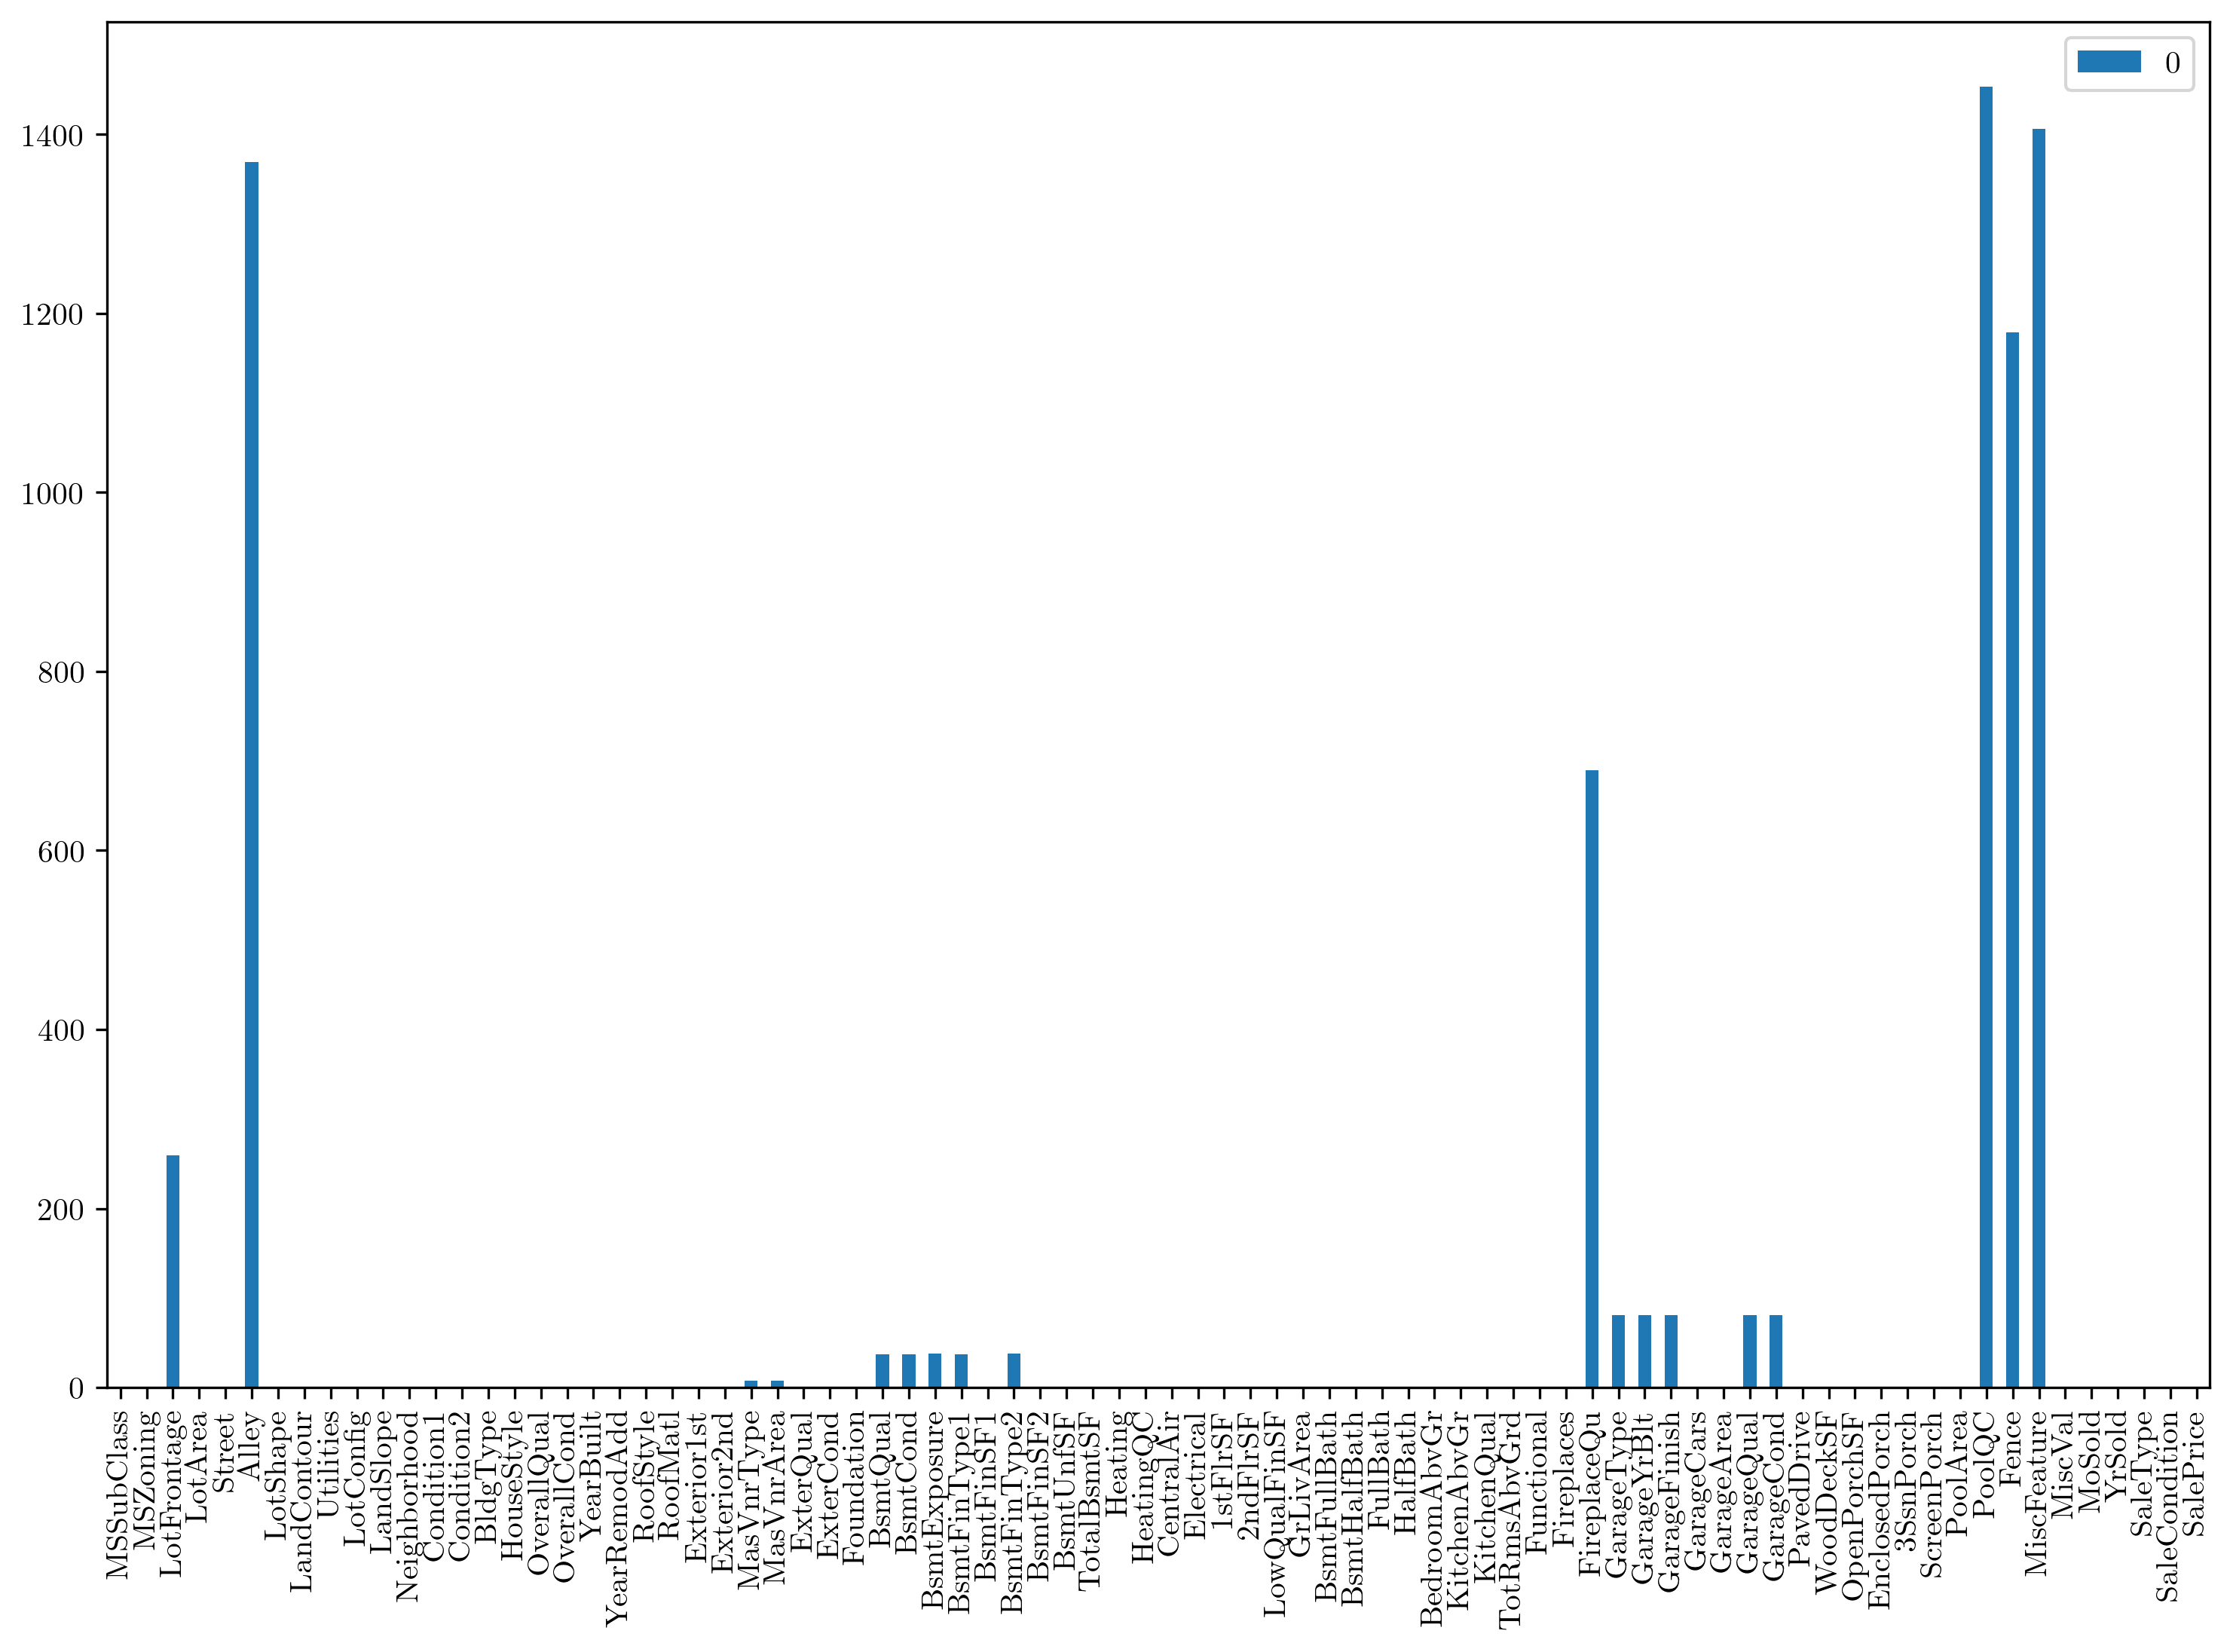

In [12]:
print('The variables with missing values')
count_missing(df).display()
plot_missing_counts(df);

For the most of the categorical variables, there is a category defined representing missing value (`NA` or `None`) in the data description. The missing values in those categorical variables can be filled with the corresponding missing value defined. 

Let's see how many of missing values can be filled as such.

In [13]:
def fill_missing_values_by_data_description(dataf):
    dataf = dataf.copy()
    for col in ORDINALS + NOMINALS:
        if col not in dataf.columns:
            continue
        val = 'NA' if col != 'MasVnrType' else 'None'
        dataf[col] = dataf[col].fillna(val)
    return dataf

The variables with missing values


,n_missing
LotFrontage,259
MasVnrArea,8


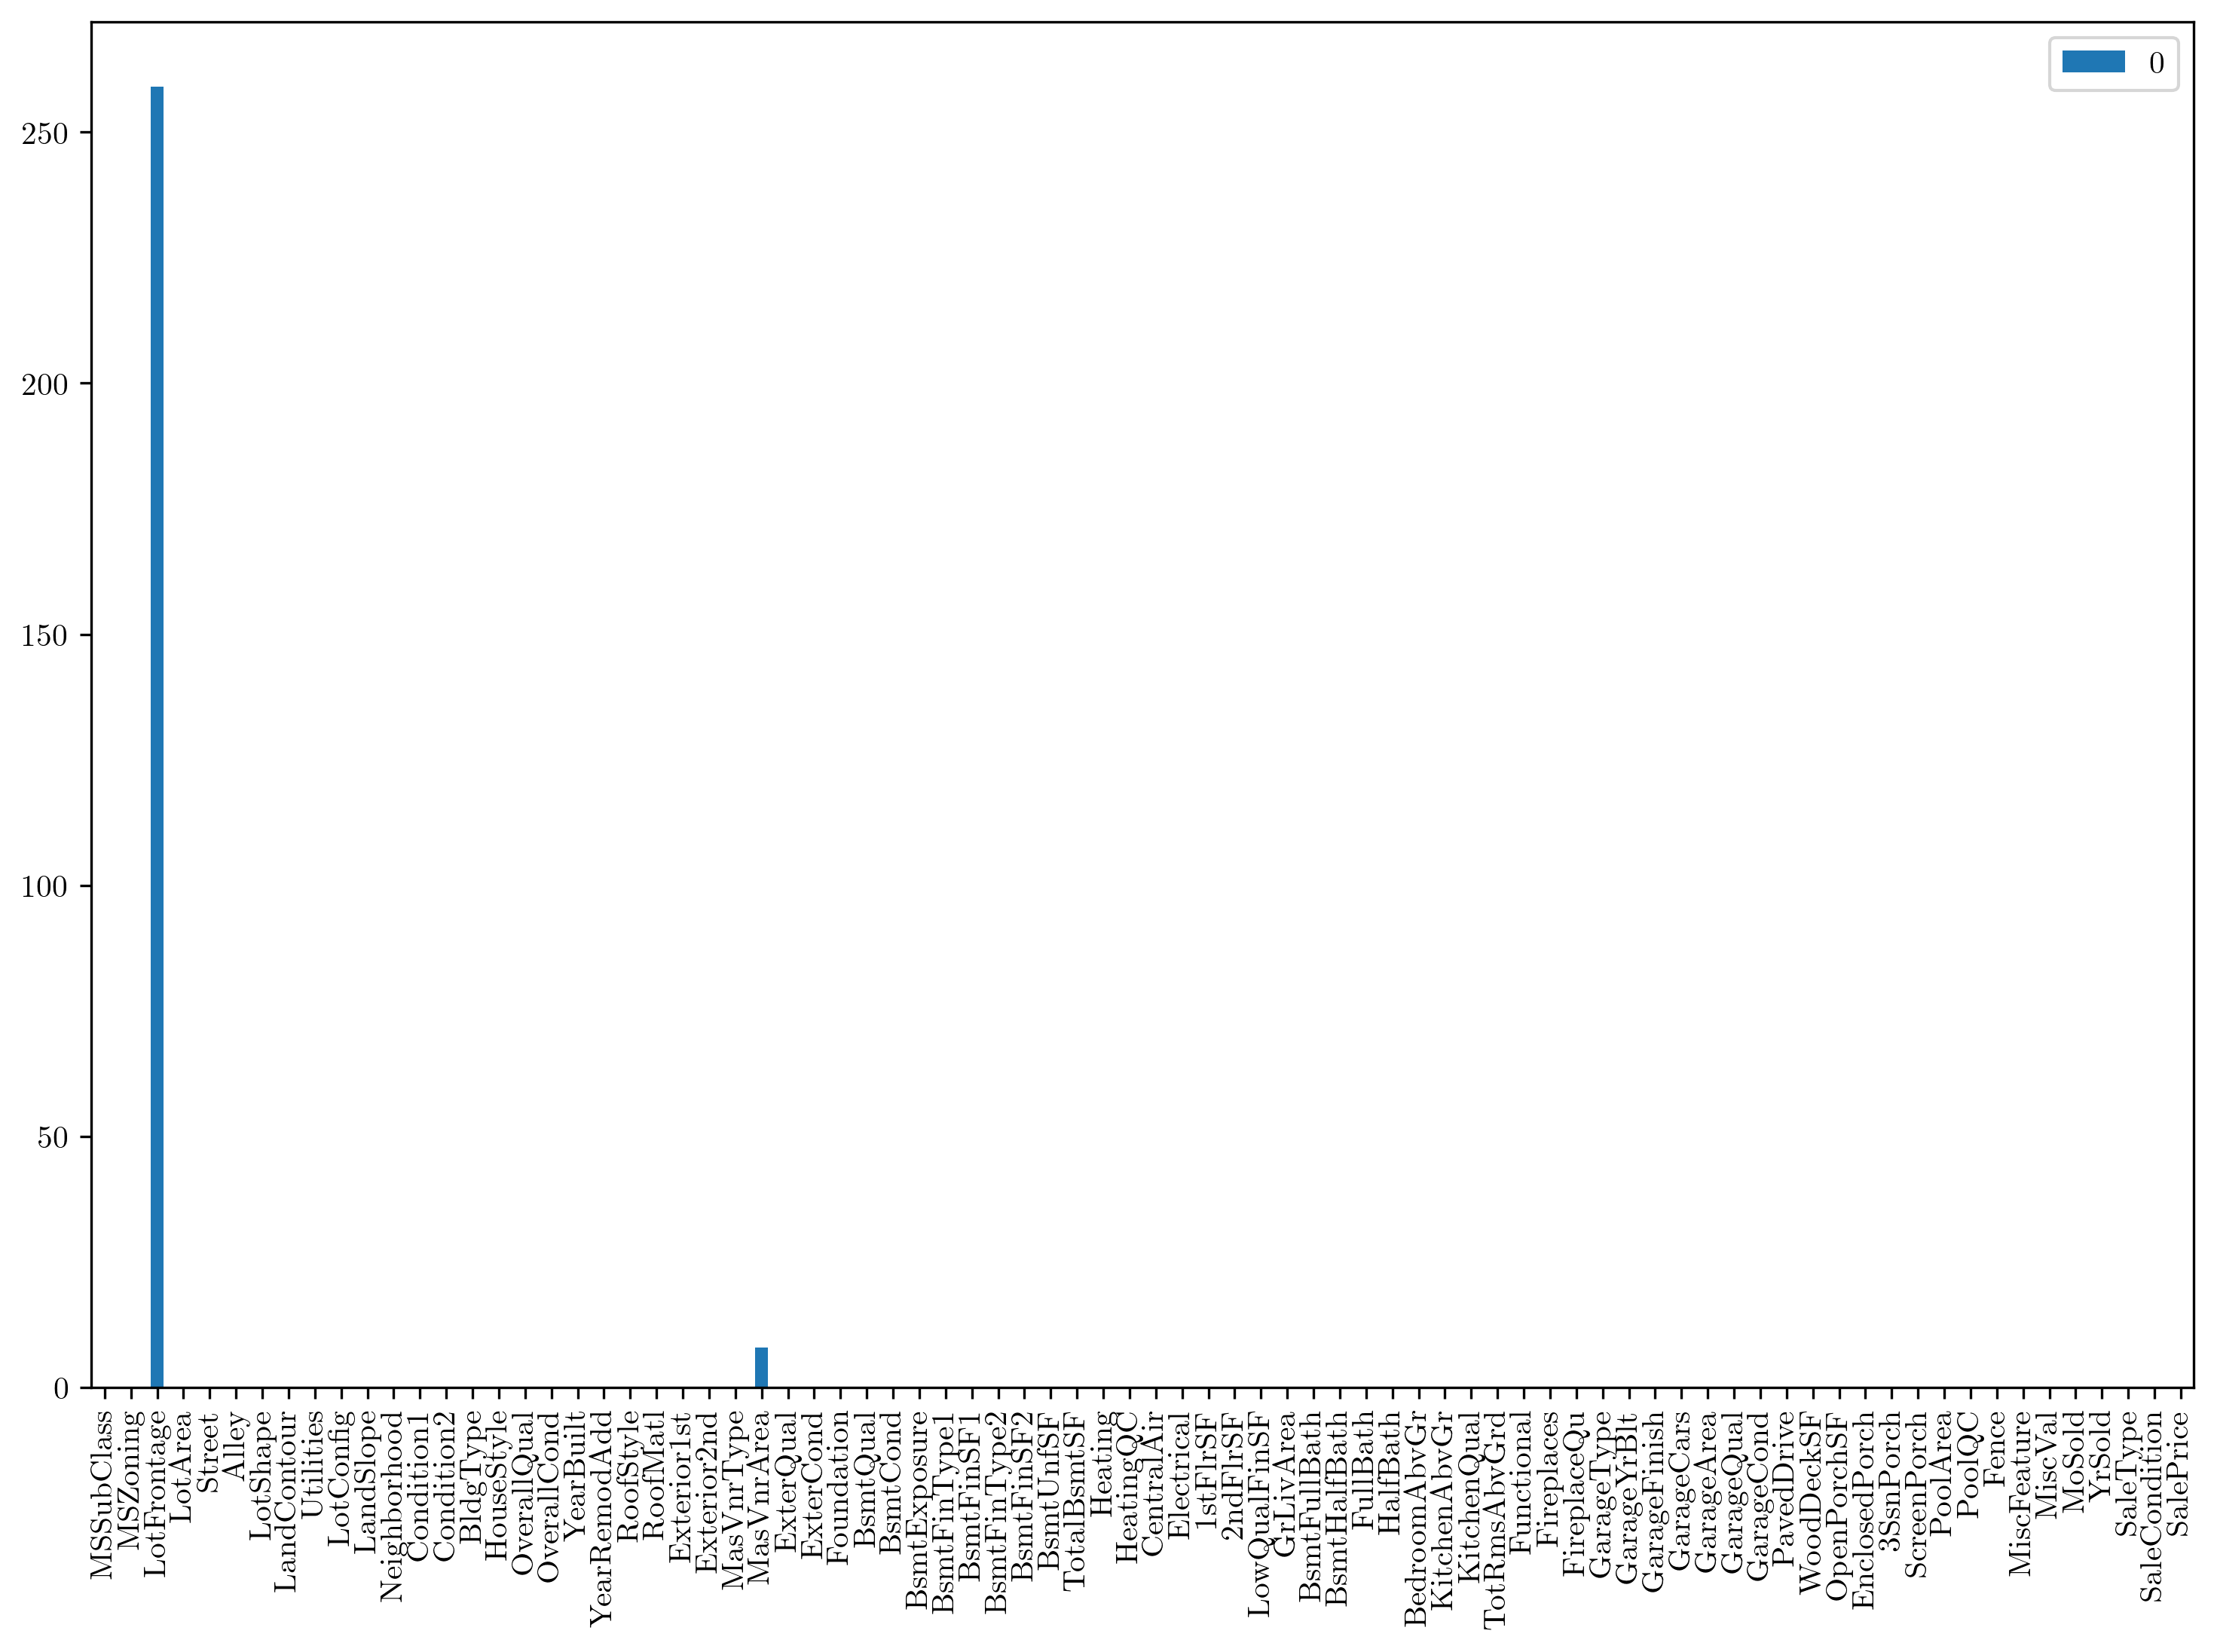

In [14]:
df = fill_missing_values_by_data_description(df)
print('The variables with missing values')
count_missing(df).display()
plot_missing_counts(df);

Only `LotFrontage` and `MasVnrArea` have missing values left. Let's check the correlation between missing values of these variables with `missingno`'s `heatmap` method.

In [17]:
def show_missingness(df):
    print("Missing rates")
    print('='*16)
    print(df.isna().sum() / len(df))
    print('='*16)

    msno.heatmap(df, figsize=(4,4))
    plt.show()

    msno.matrix(df, figsize=(4,4))
    plt.show()

Missing rates
MSSubClass       0.000000
MSZoning         0.000000
LotFrontage      0.177397
LotArea          0.000000
Street           0.000000
                   ...   
MoSold           0.000000
YrSold           0.000000
SaleType         0.000000
SaleCondition    0.000000
SalePrice        0.000000
Length: 80, dtype: float64


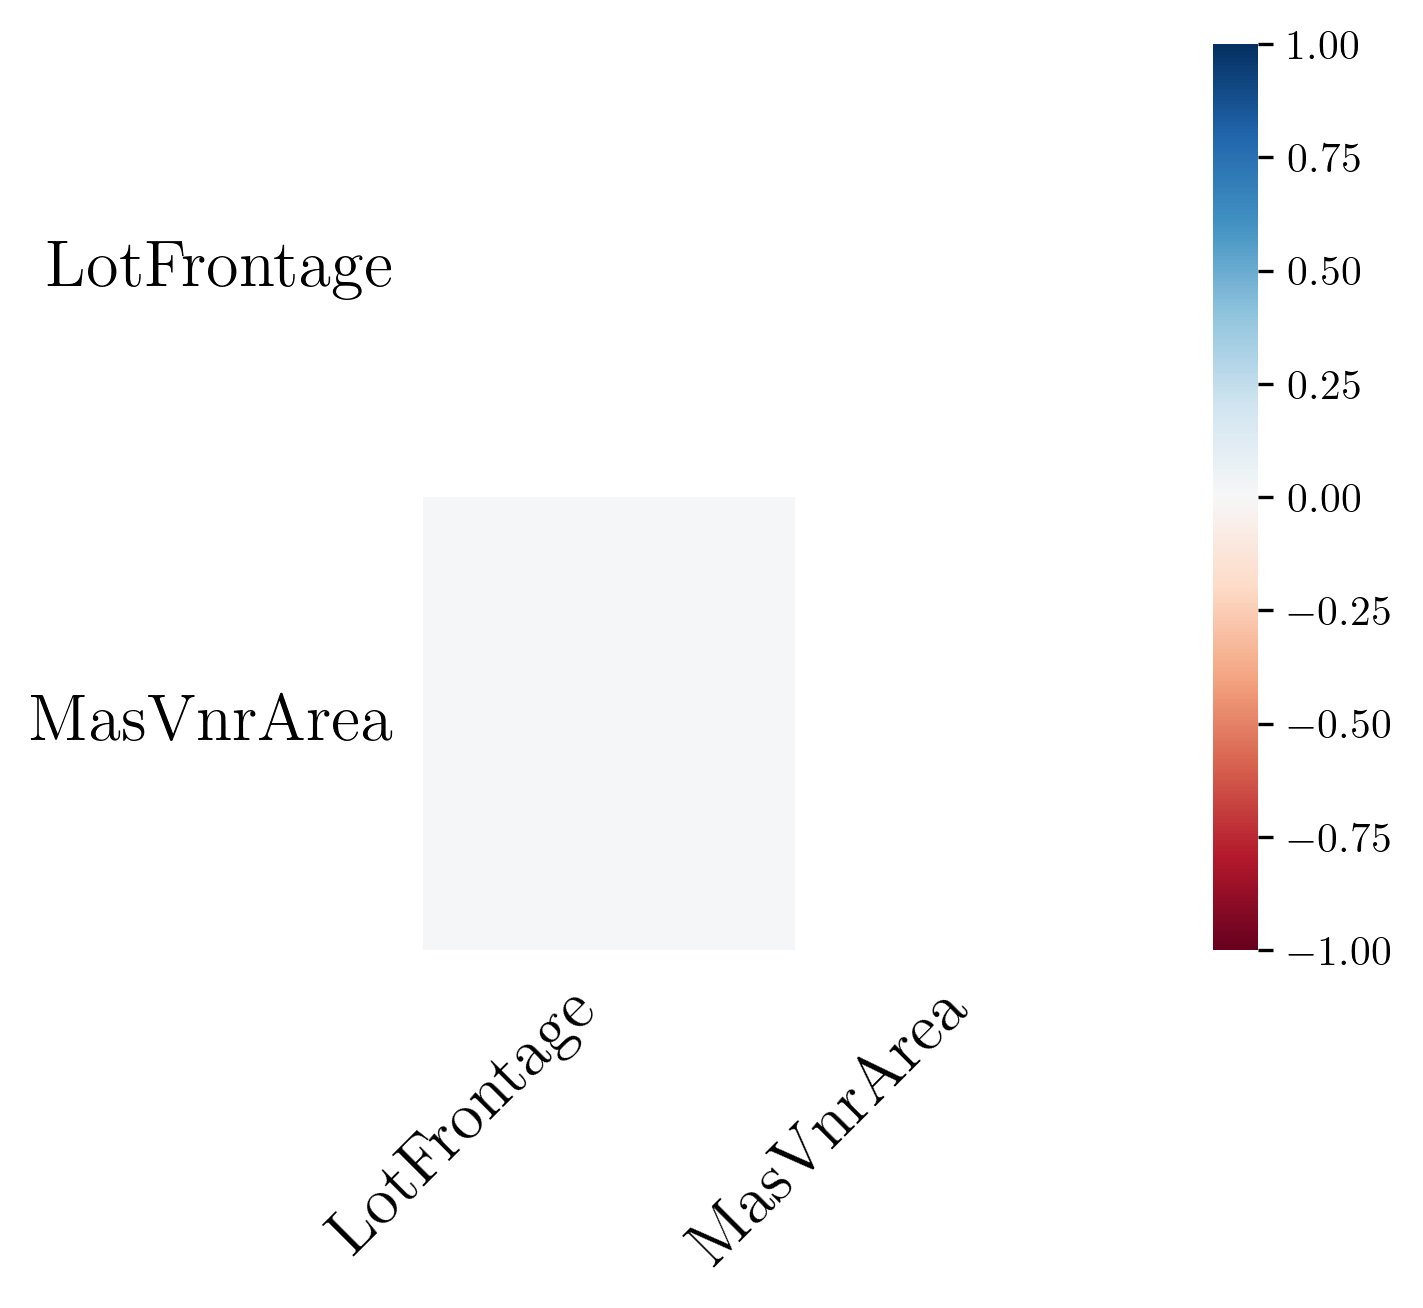

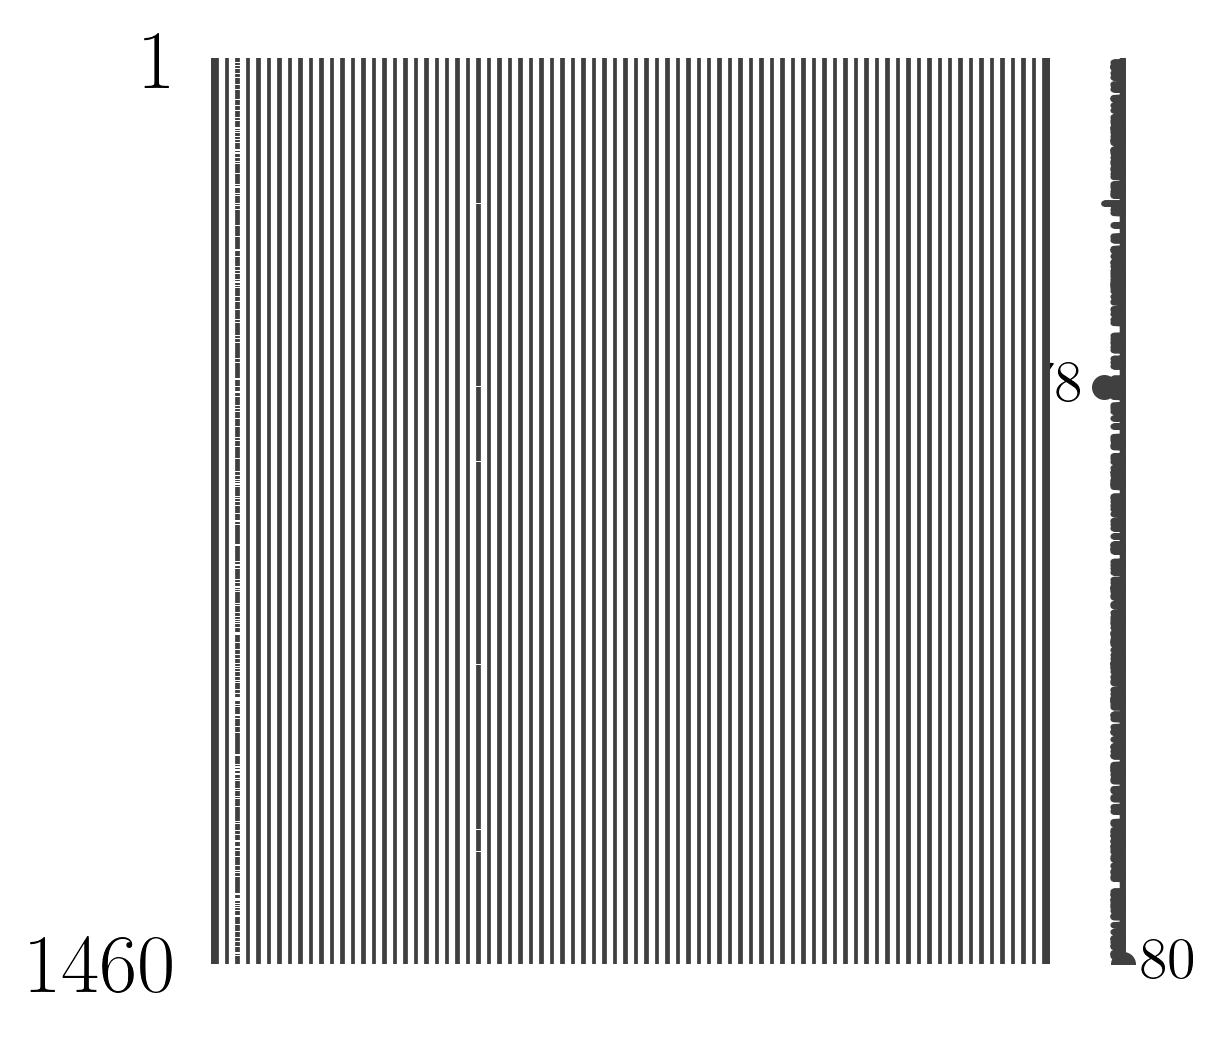

In [18]:
show_missingness(df)

There isn't any strong correlation between missing values of `LotFrontage` and `MasVnrArea`, hence, we'll assume the missingness mechanism for these variables are MCAR and use simple imputation methods.

The missing values in the categorical variables will be imputed with most frequent value in the training set.

Let's set the `dtype`'s of the variables according to the dataset definition.

In [19]:
def prepare_dataset(df):
    df = df.pipe(fill_missing_values_by_data_description)

    for col in NUMERICALS:
        if col not in df.columns:
            continue
        df[col] = df[col].astype('float')
    
    for col, categories in ORDINALS_INFO:
        if col not in df.columns:
            continue
        df[col] = df[col].astype(CategoricalDtype(categories=categories, ordered=True))
    
    for col in NOMINALS:
        if col not in df.columns:
            continue
        df[col] = df[col].astype('category')
    
    existing_cols = set(df.columns)
    col_order =  [col for col in NUMERICALS + ORDINALS + NOMINALS if col in existing_cols]
    return df[col_order]

In [20]:
df = prepare_dataset(df)

## Data distribution

Let's visualize the distribution of variables.

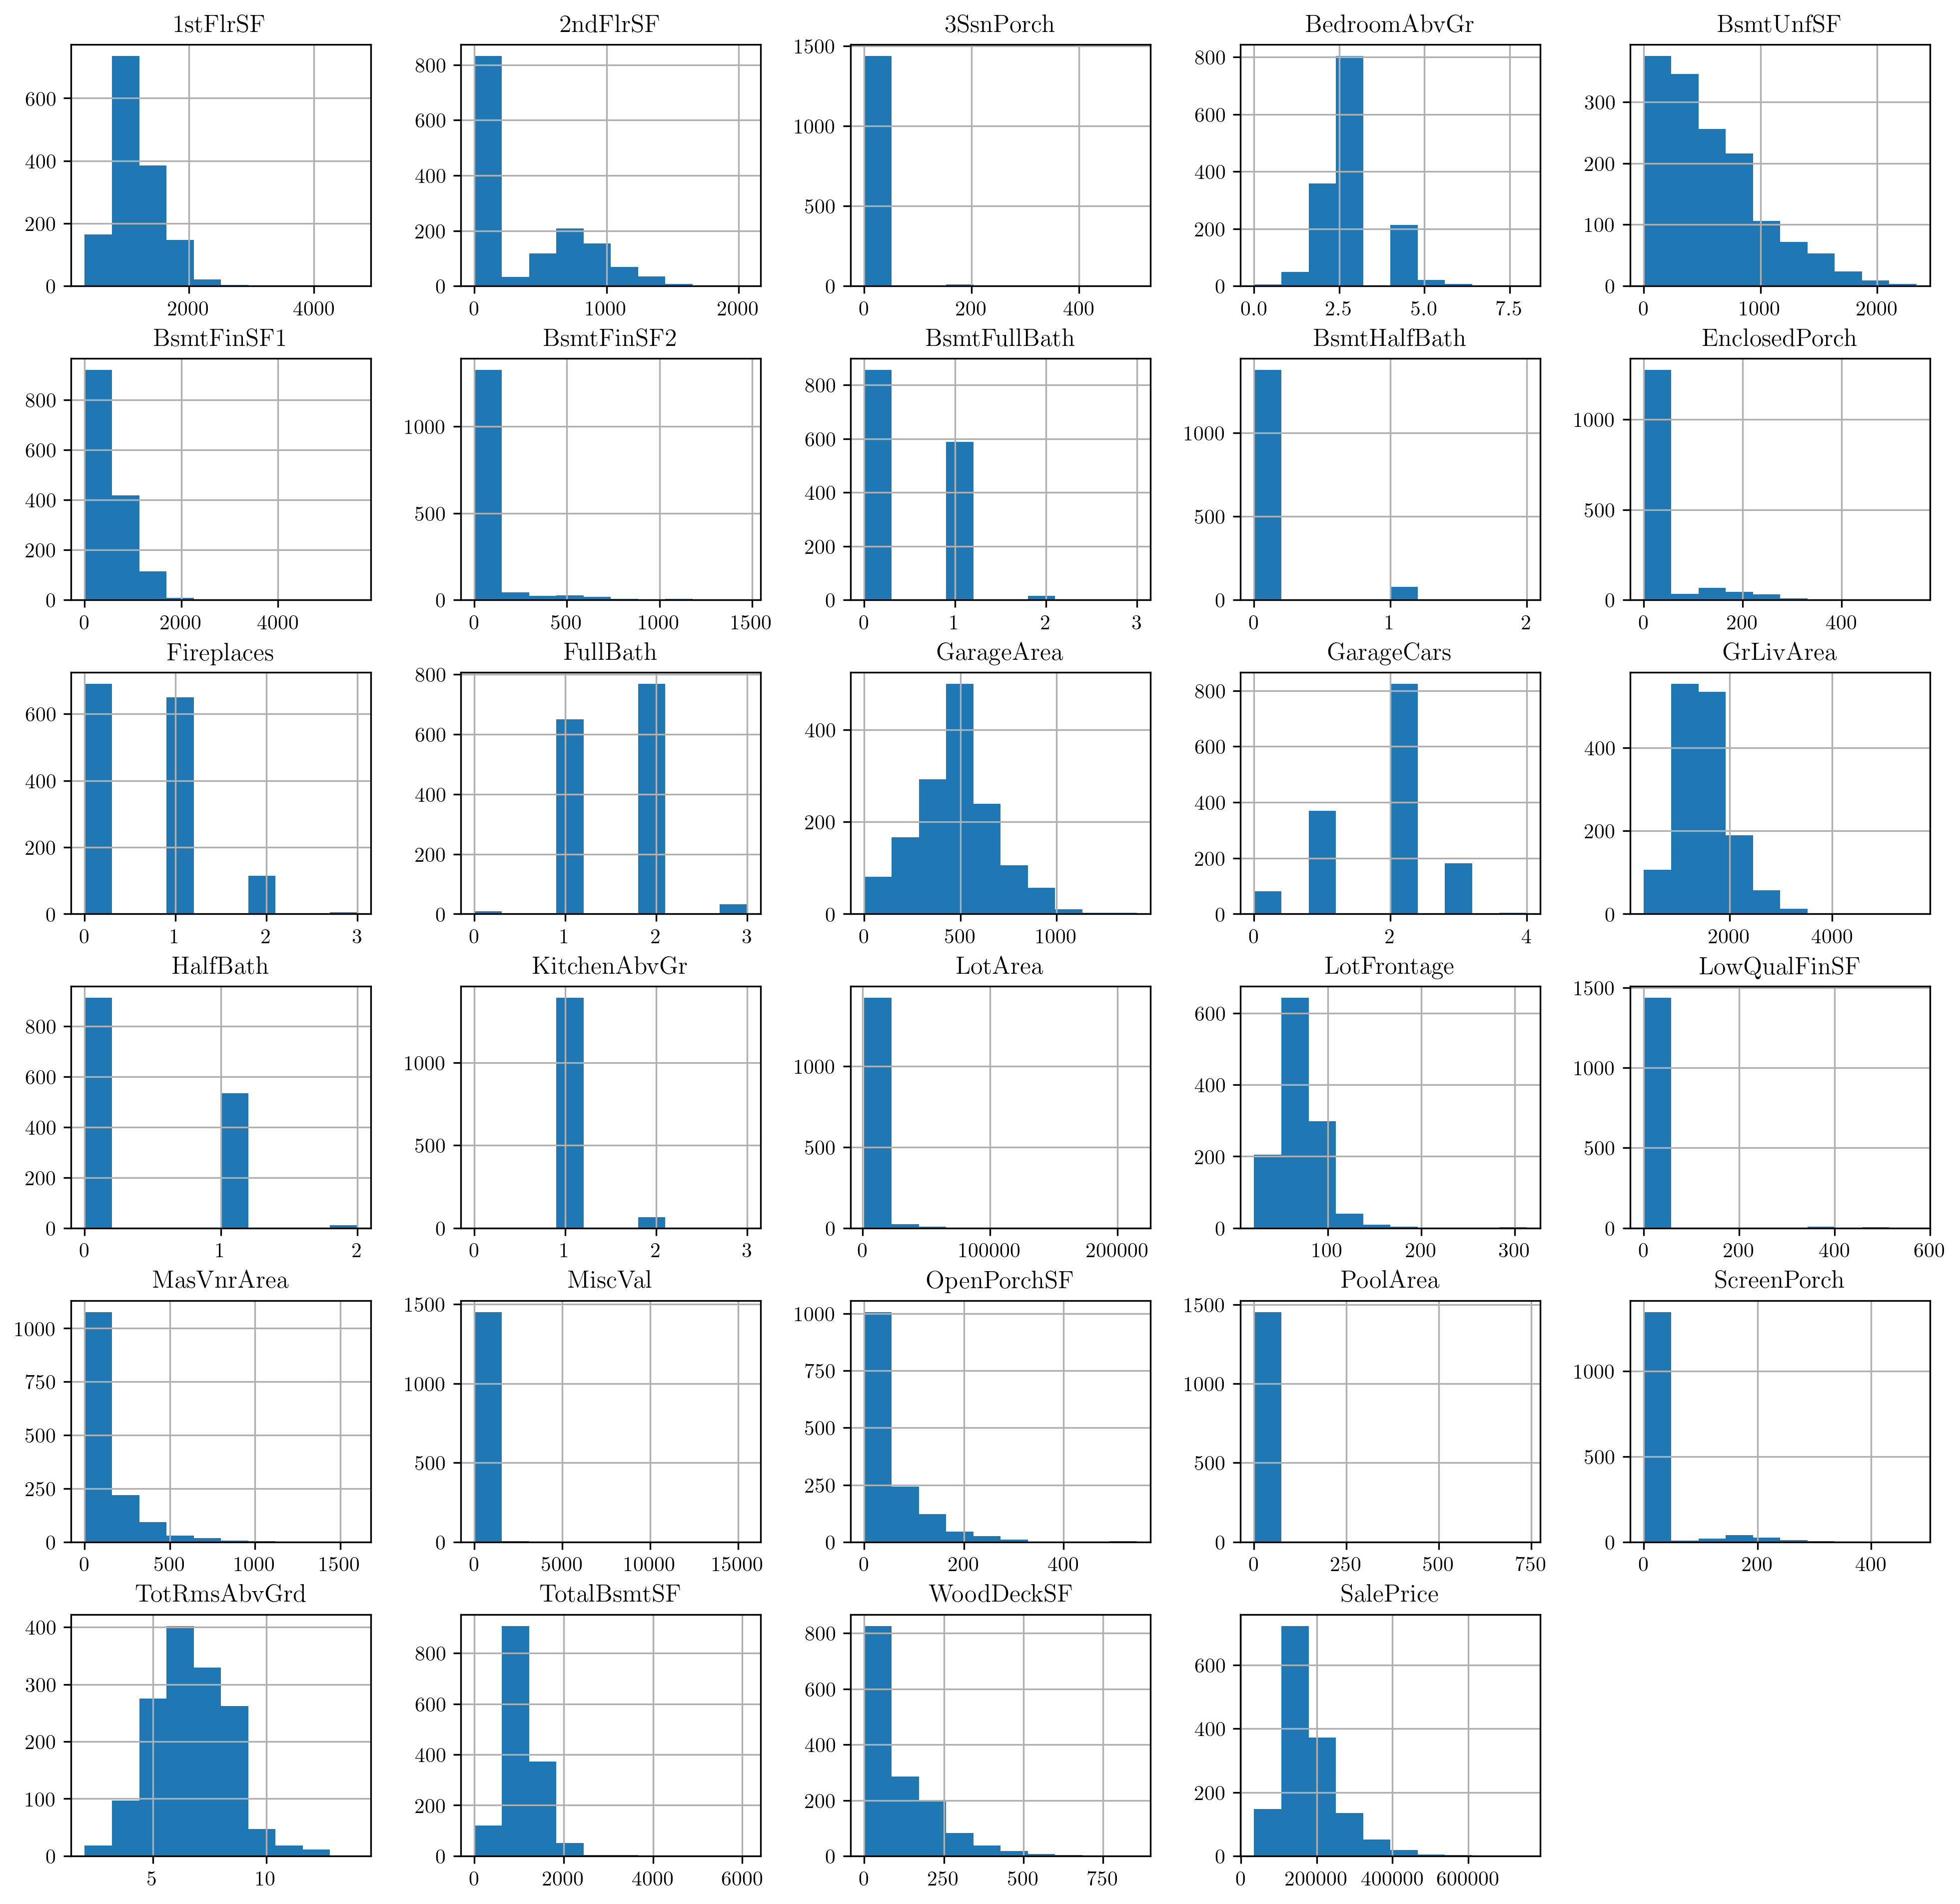

In [21]:
df[NUMERICALS].hist(figsize=(16, 16));
savefig('numericals-histogram')


`FullBath`, `GarageArea`, `GarageCars`, and `TotRmsAbvGrd` have roughly symmetrical distributions. Other numerical variables has varying level of skewness.
Let's compute skewness values for all numerical variables.

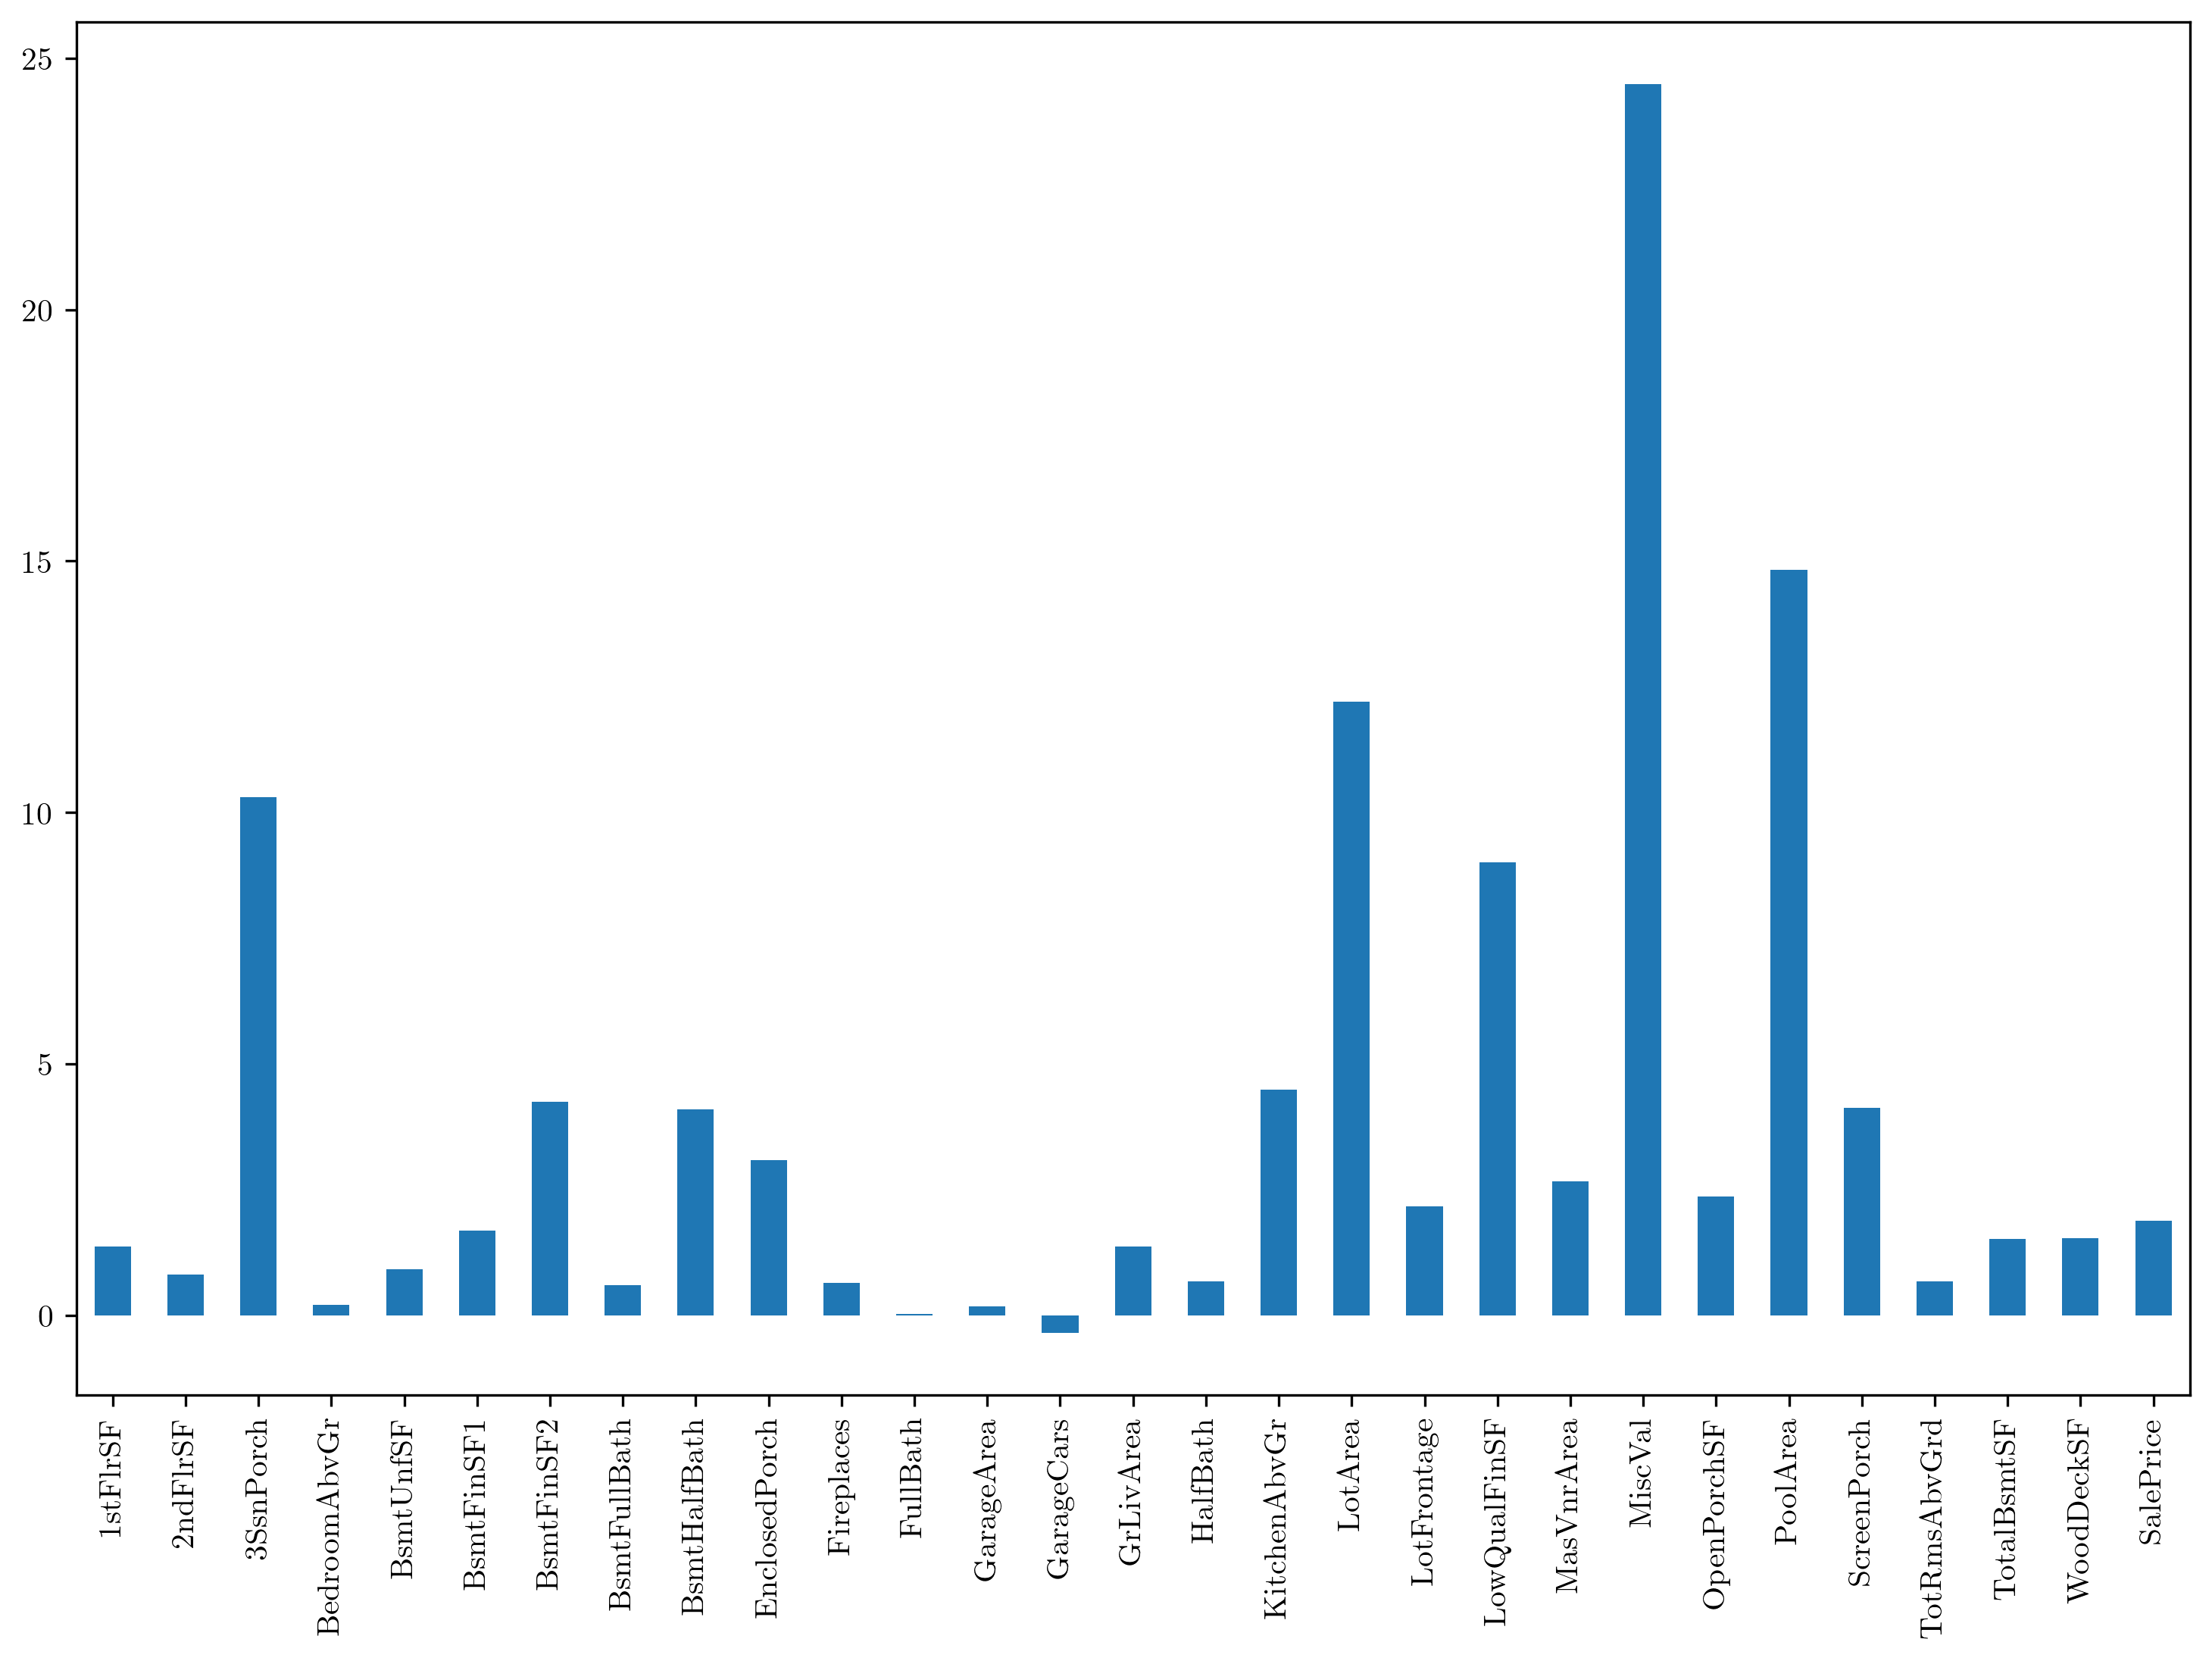

In [23]:
df[NUMERICALS].skew().plot(kind='bar', figsize=(12, 8))
savefig('numericals-skewness-bar')

As it's seen, most of the numerical variables are positively skewed.

Let's do the same analysis for ordinal variables.

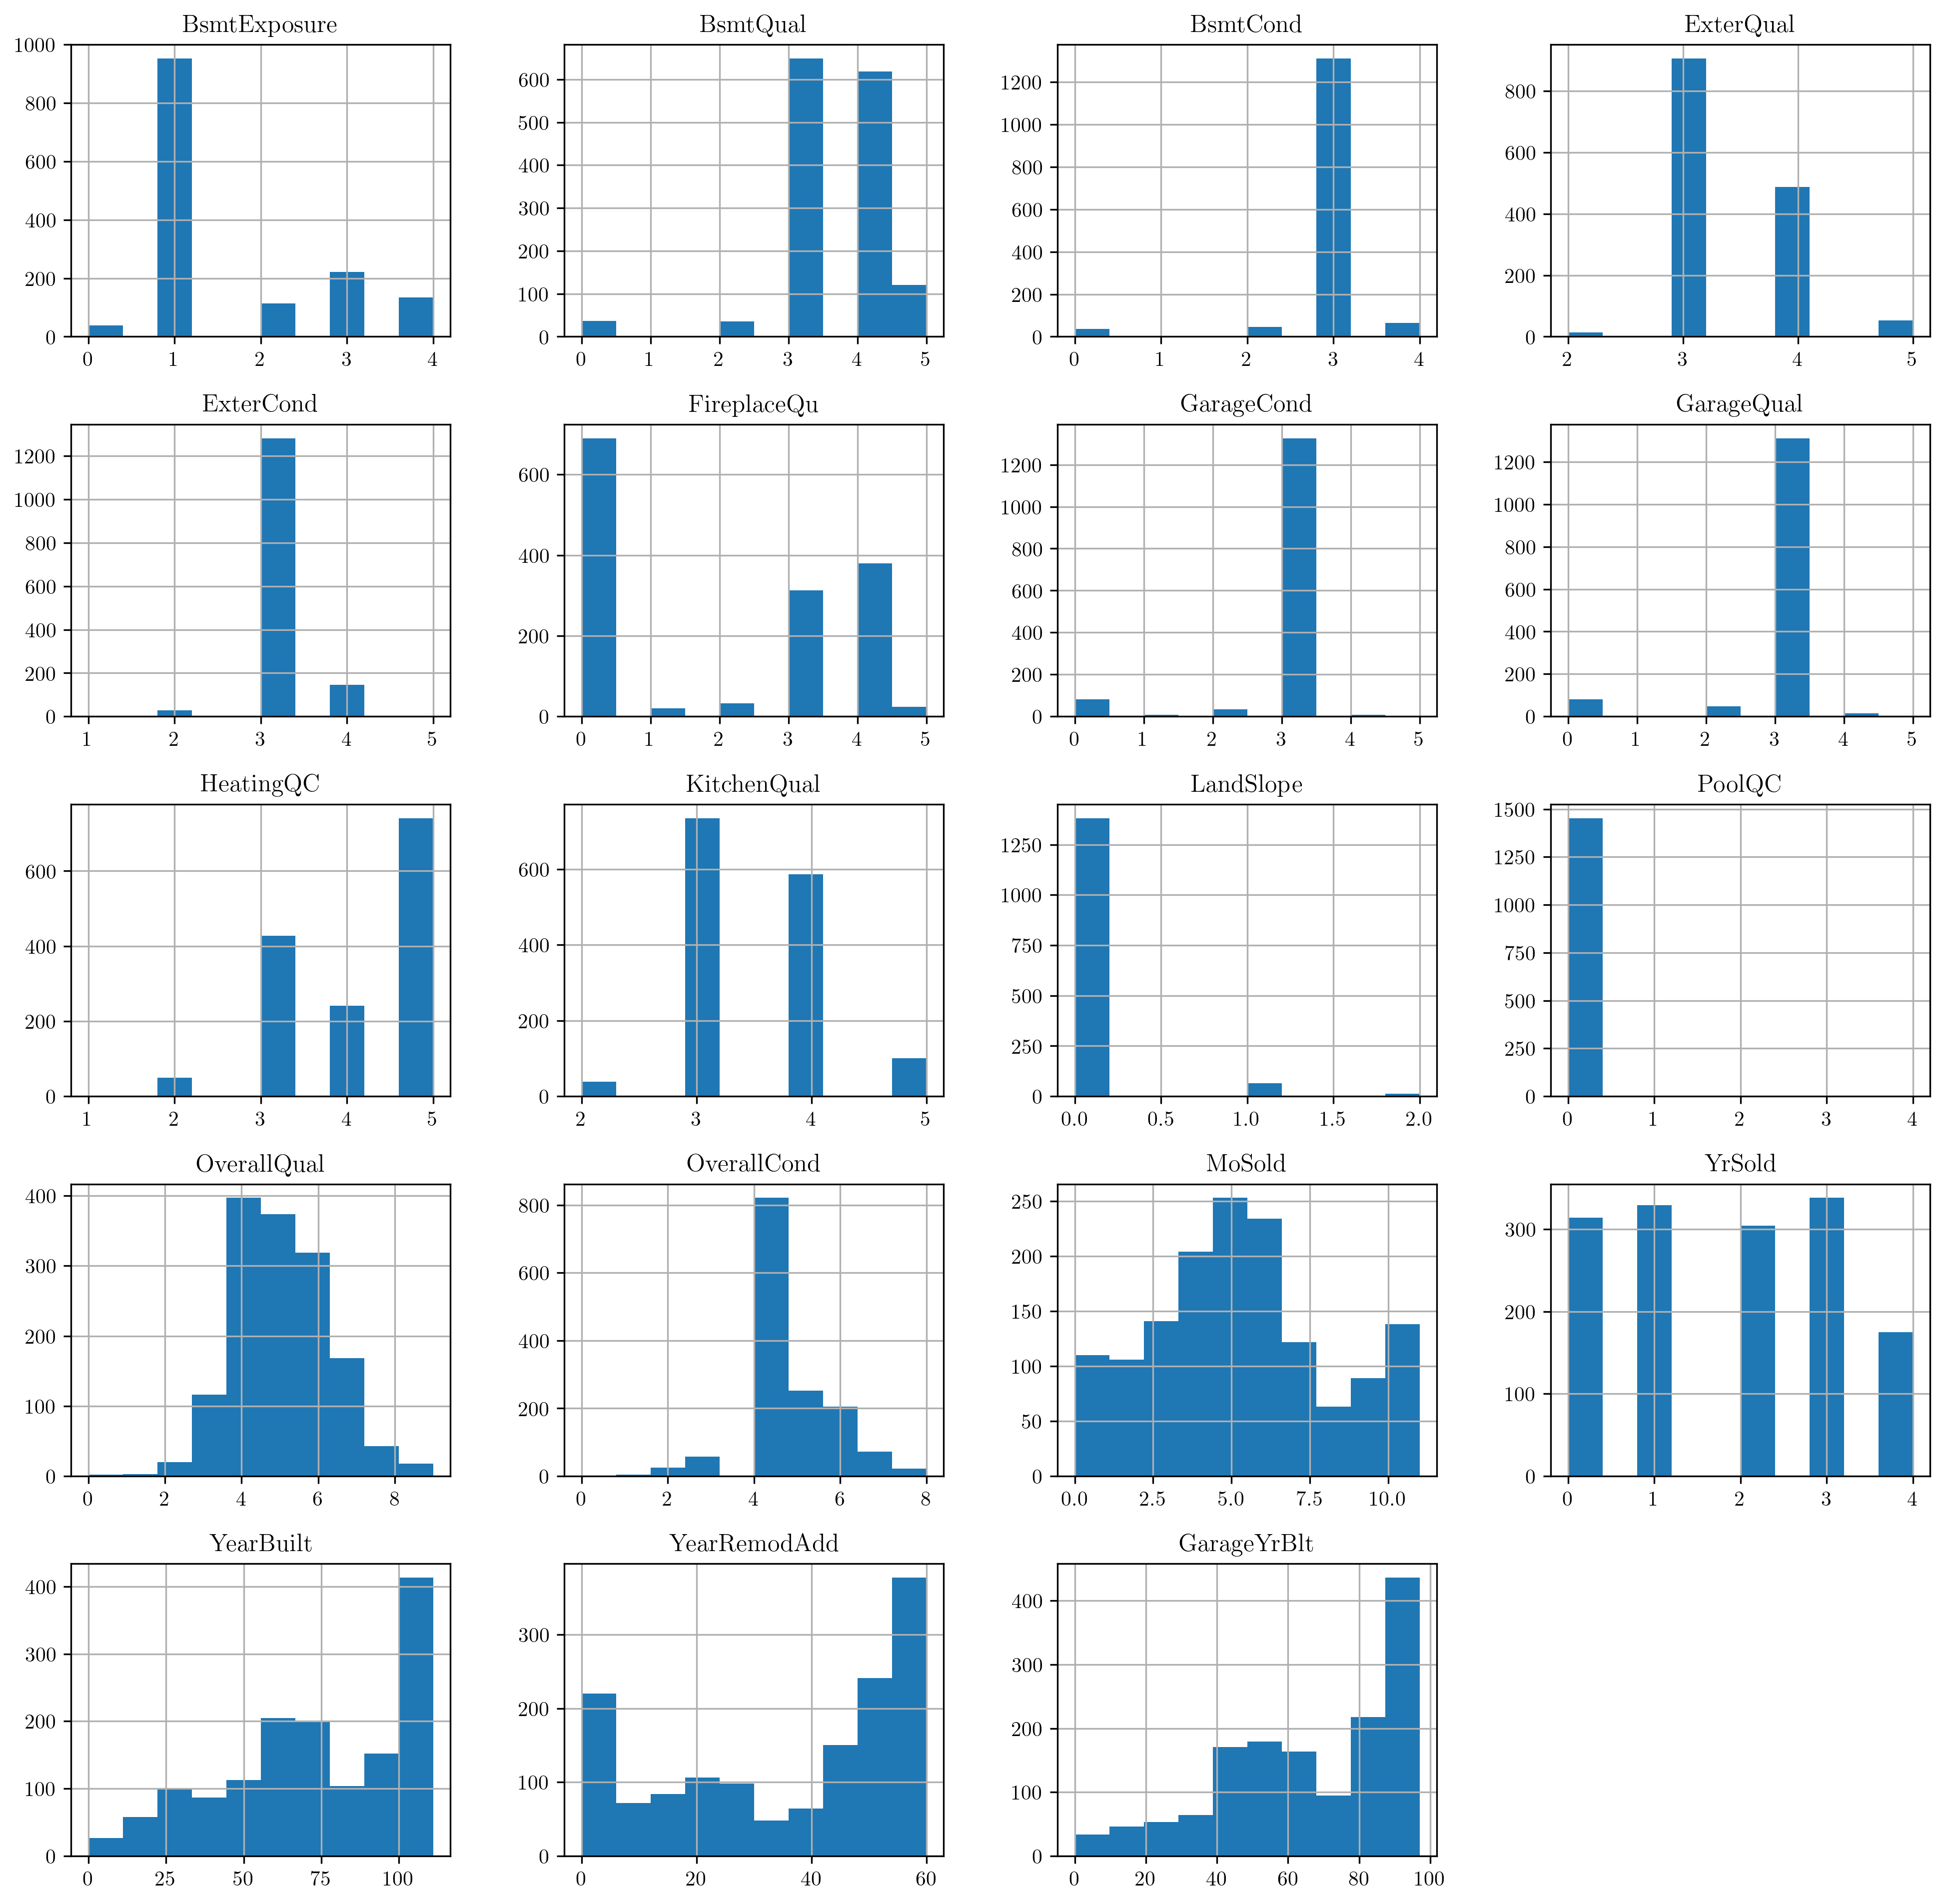

In [24]:
ordinal_df = df[ORDINALS].apply(lambda ser: ser.cat.codes)
ordinal_df.hist(figsize=(16, 16));
savefig('ordinals-histogram')

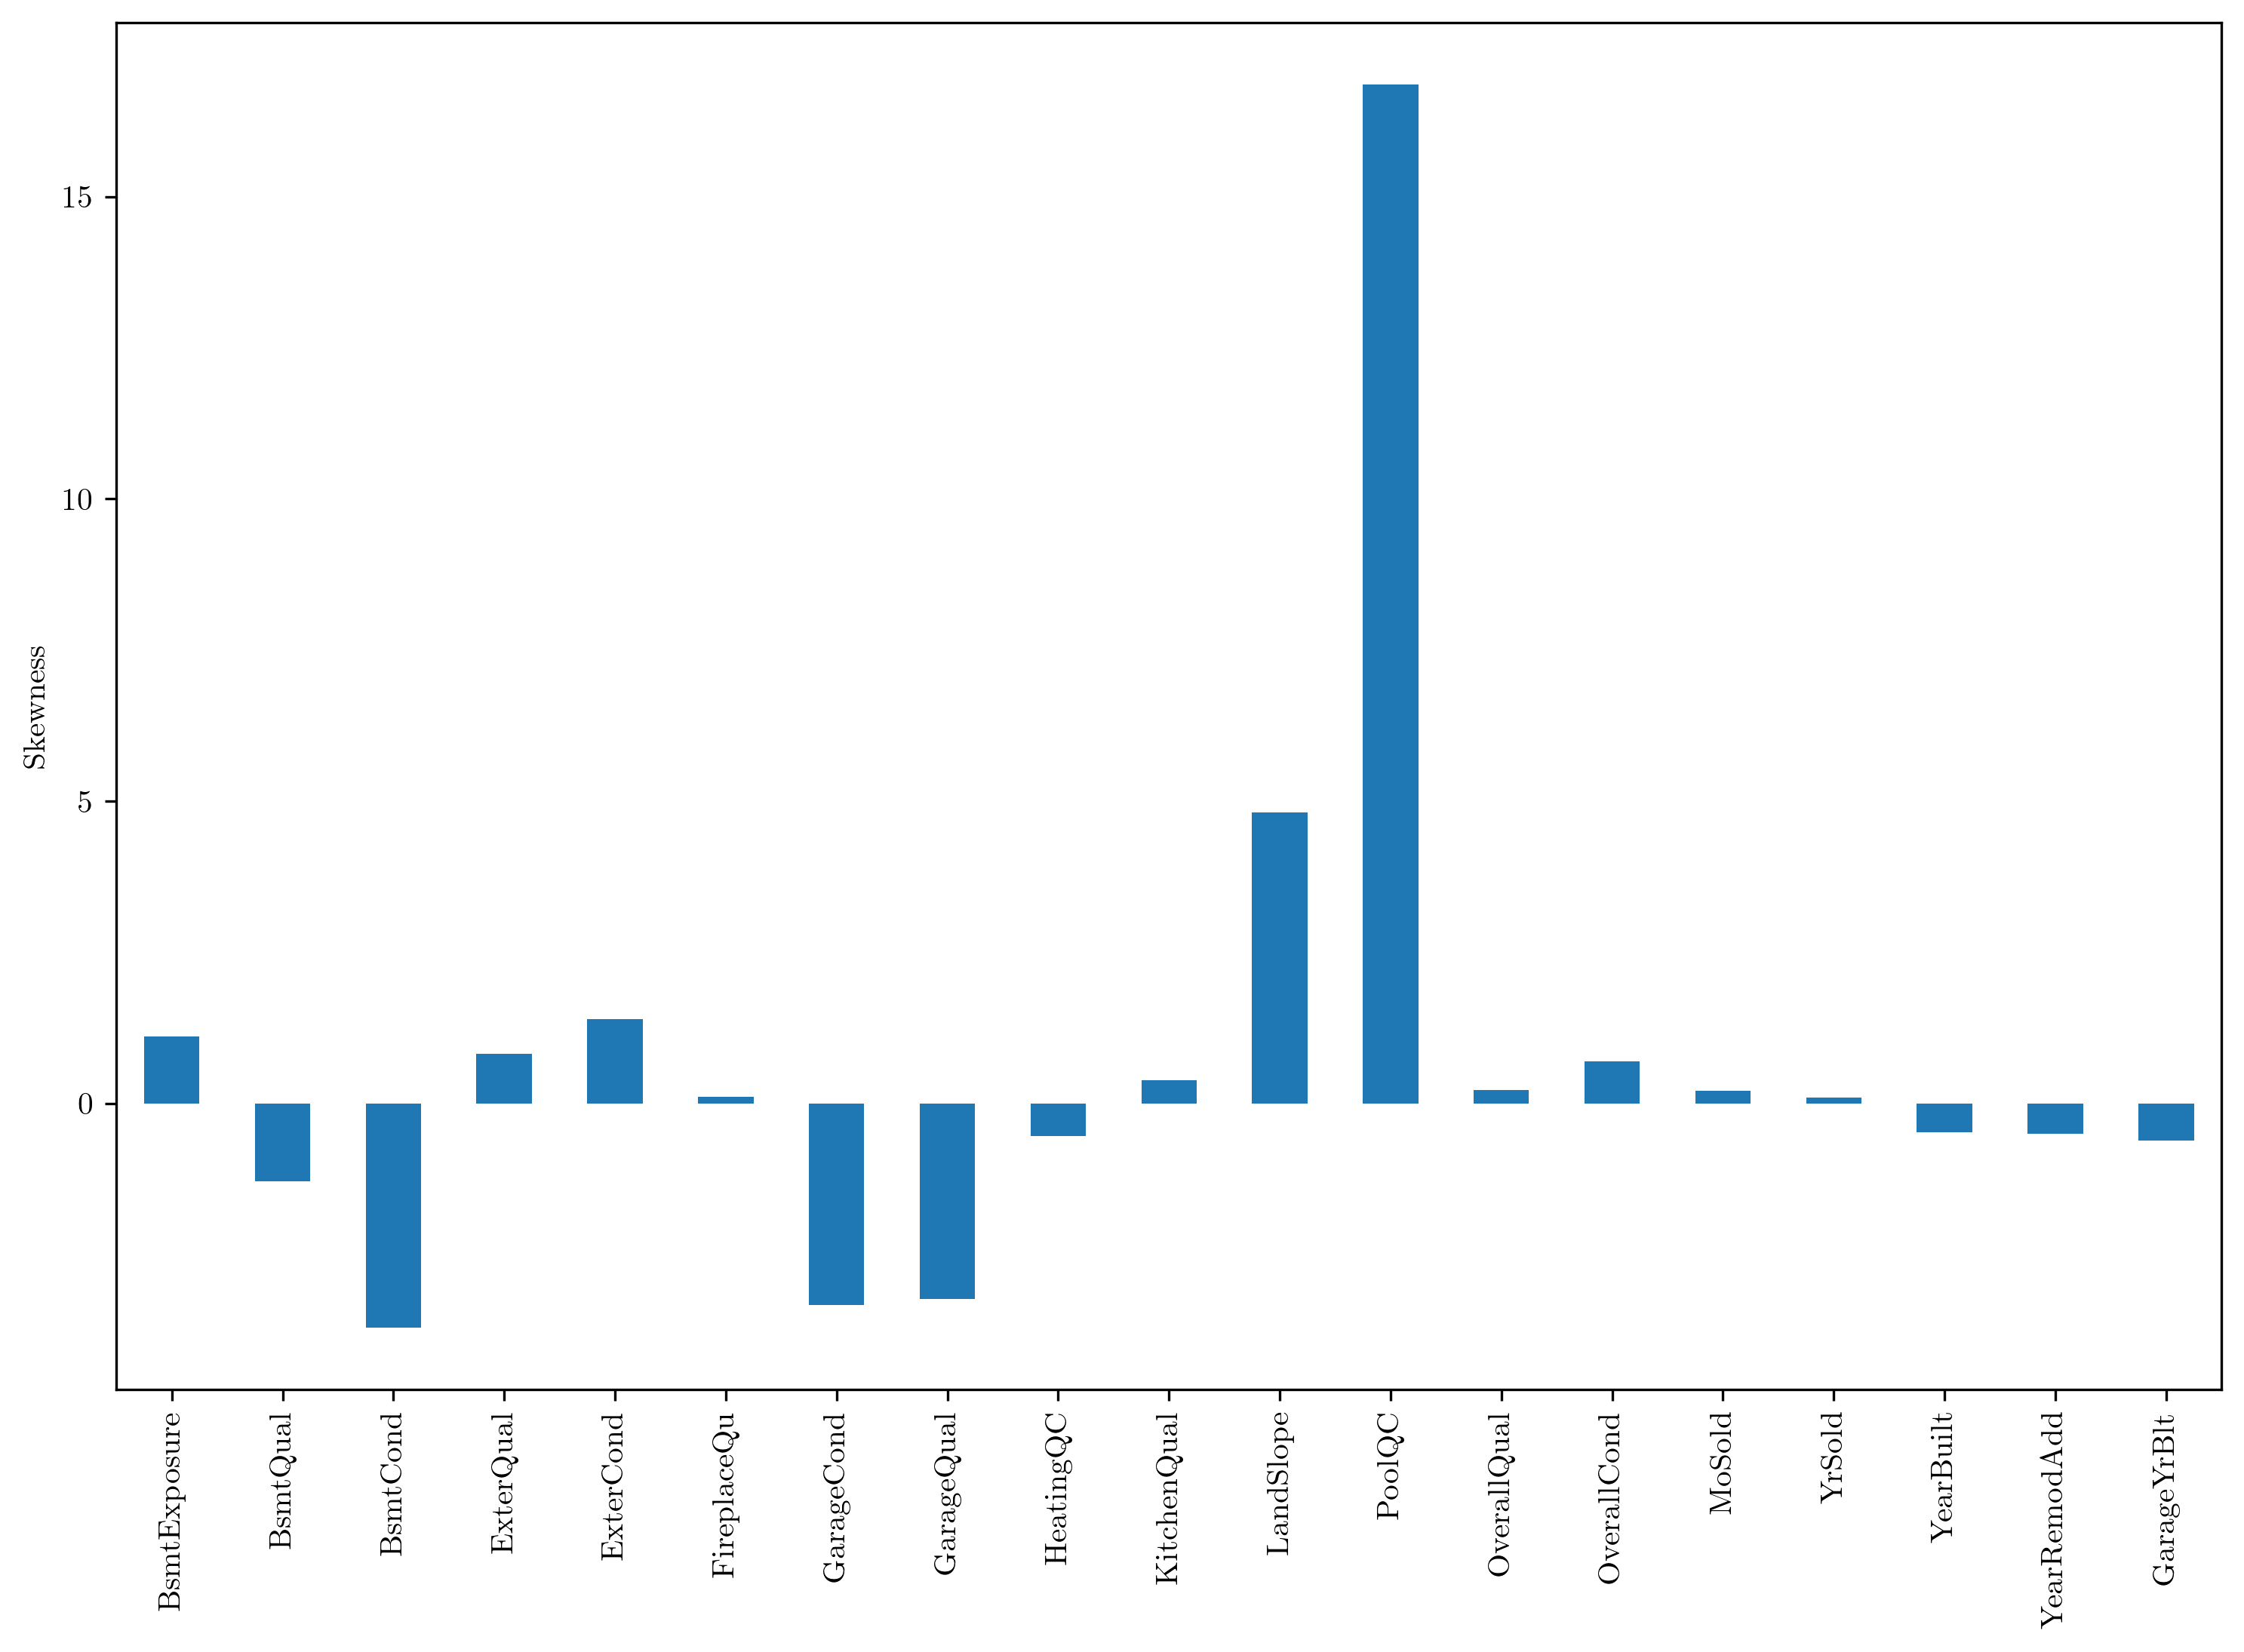

In [25]:
ordinal_df.skew().plot(kind='bar', figsize=(12, 8));
plt.ylabel('Skewness')
plt.savefig('ordinals-skewness-bar')

As it's seen, most of the ordinal variables have skewed distributions.

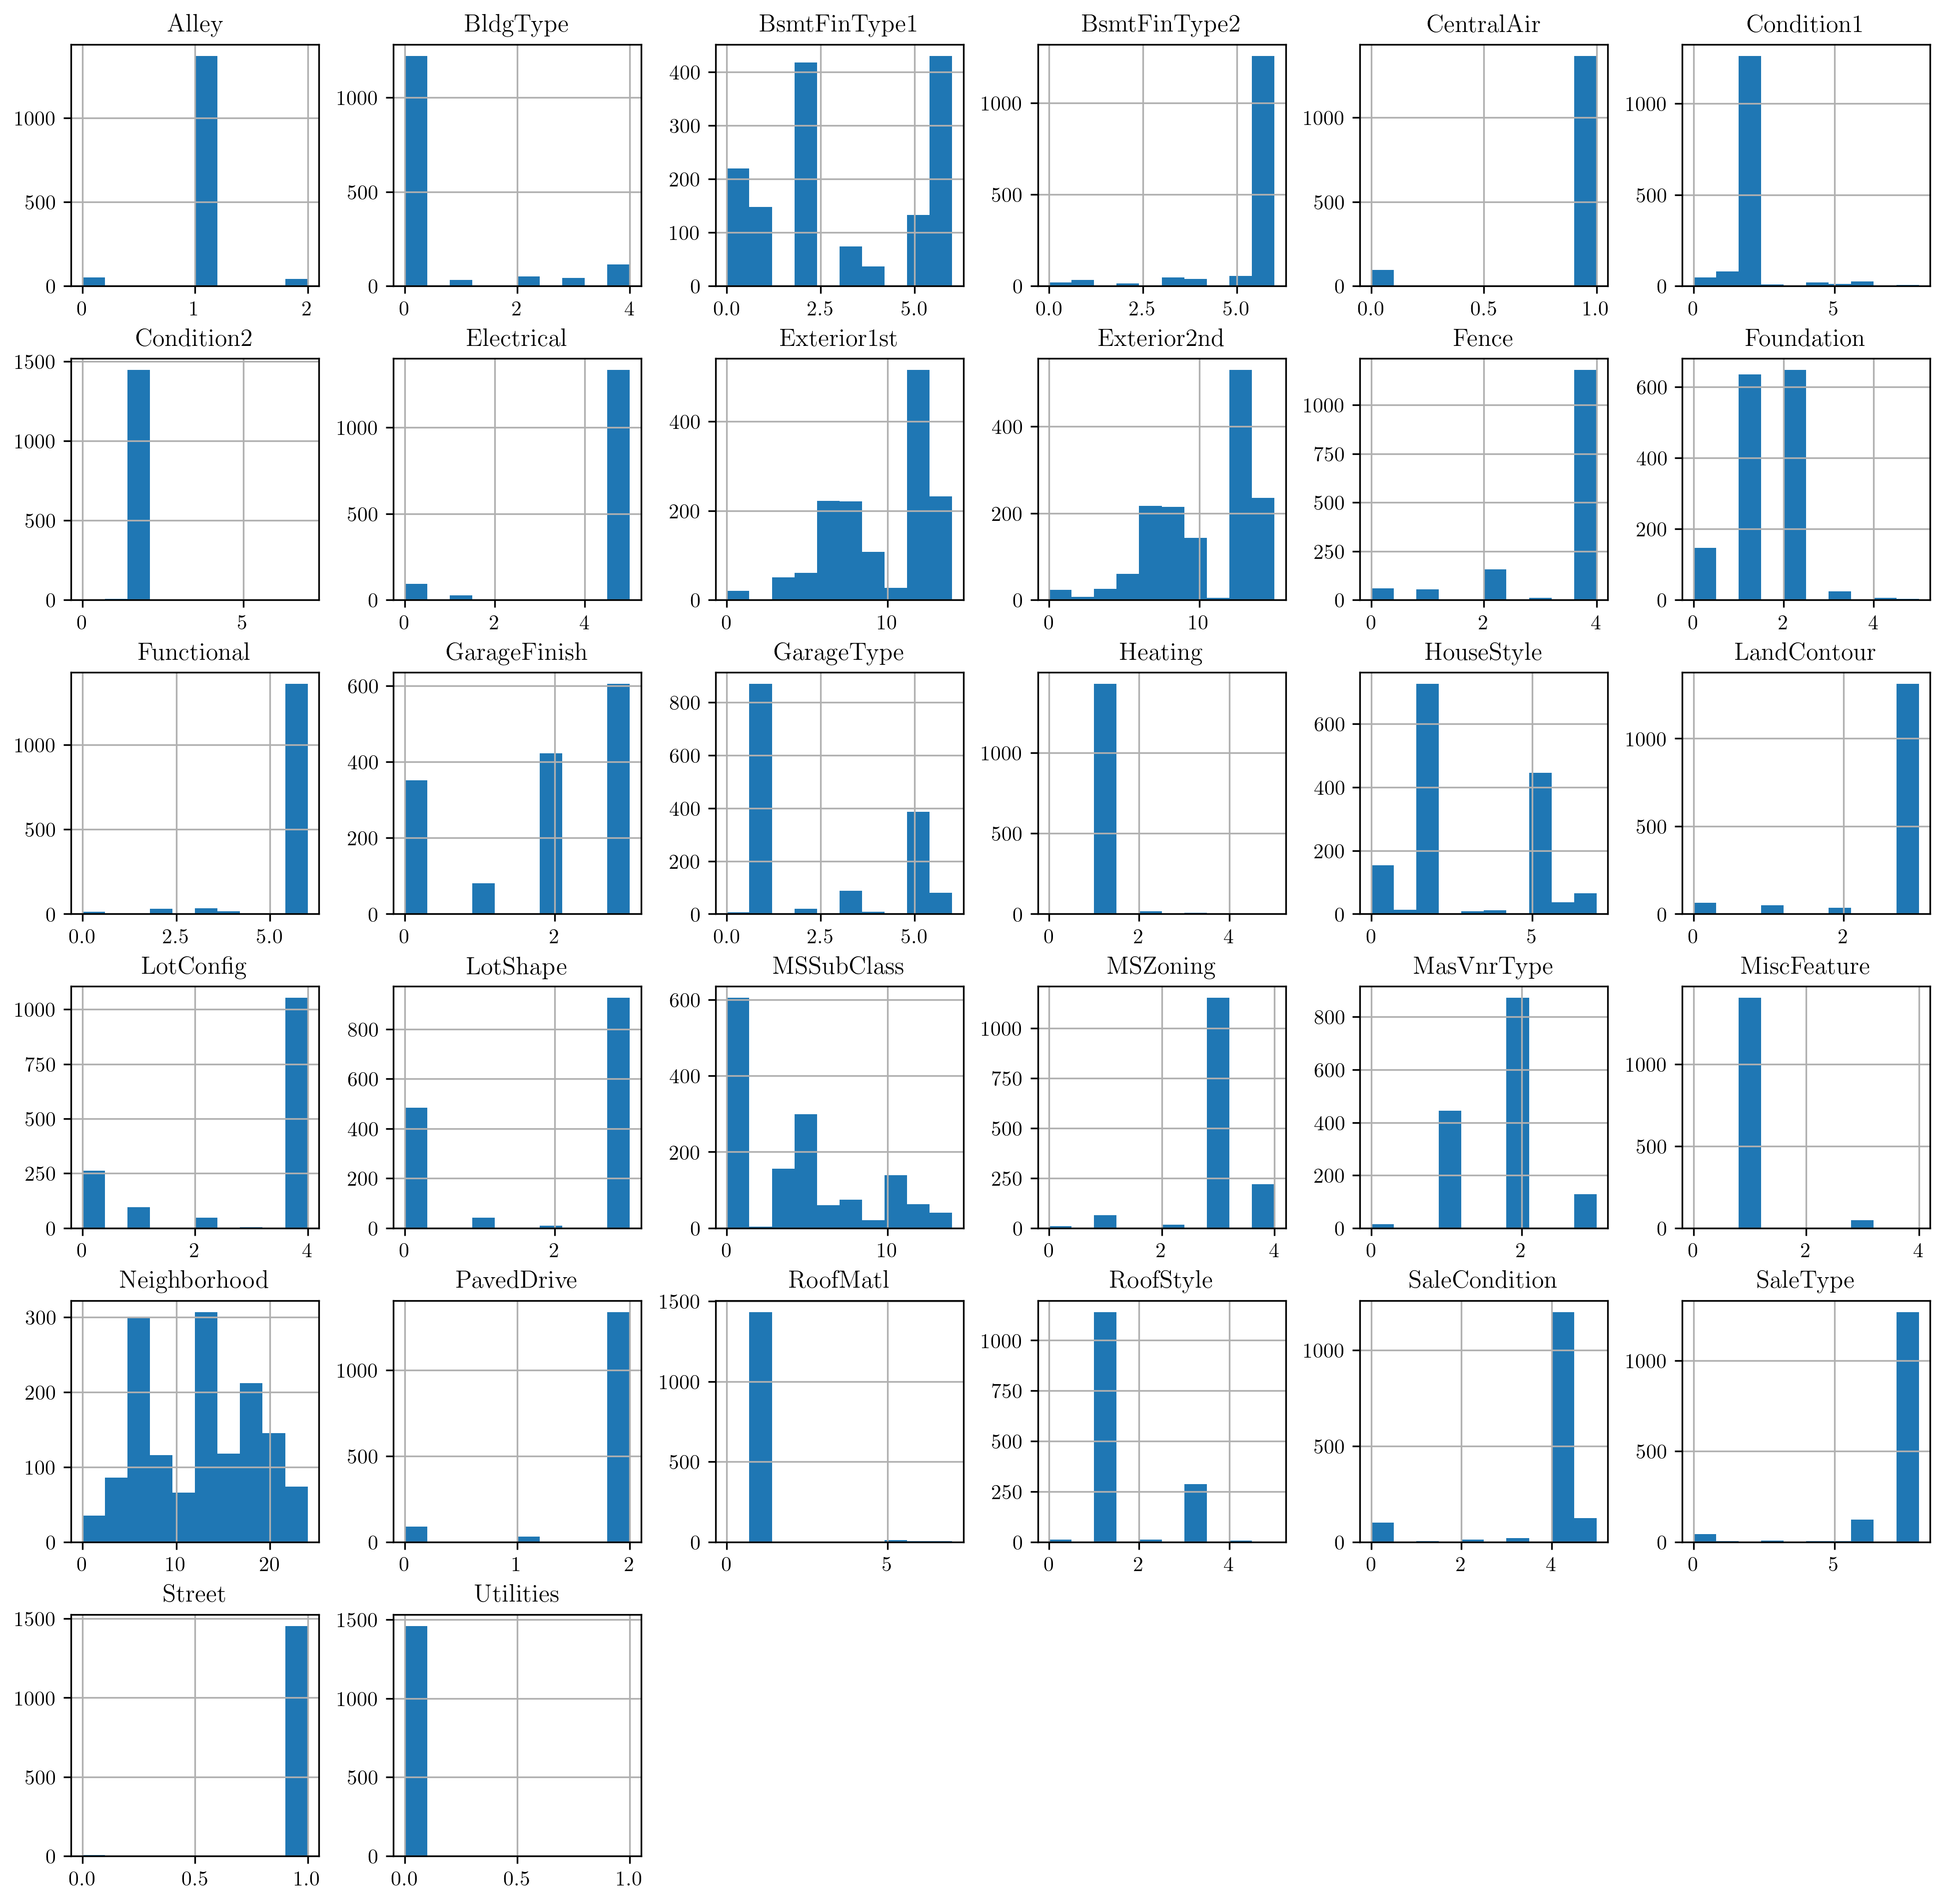

In [26]:
nominal_df = df[NOMINALS].apply(lambda ser: ser.cat.codes)
nominal_df.hist(figsize=(16, 16));

The numerical variables with symmetrical distribution, i.e. the ones with skewness value less than 0.5, are standardized. Whereas, the numerical variables with skewed distribution, i.e. with skewness value greater than 0.5, are scaled with min-max scaling.

All preprocessing use the statistical features of training set to prevent information leakage from training to evaluation.